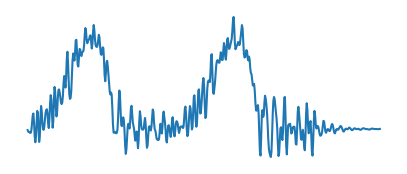

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter, spectrogram, welch
from scipy.io import loadmat, wavfile, savemat
#from scipy.linalg import solve_toeplitz
import librosa
from IPython.display import Audio

# direct translation from the voicebox matlab code
def v_glotlf(d=0, t=None, p=None):
    if p is None:
        p = np.array([0.6, 0.1, 0.2])
    elif len(p) < 3:
        default_p = np.array([0.6, 0.1, 0.2])
        p = np.concatenate([p, default_p[len(p):]])

    if t is None:
        tt = np.linspace(0, 0.99, 100)
    else:
        tt = t - np.floor(t)  # only interested in the fractional part of t

    te = p[0]
    mtc = te - 1
    e0 = 1
    wa = np.pi / (te * (1 - p[2]))
    a = -np.log(-p[1] * np.sin(wa * te)) / te
    inta = e0 * ((wa / np.tan(wa * te) - a) / p[1] + wa) / (a**2 + wa**2)

    rb0 = p[1] * inta
    rb = rb0
    for _ in range(4):
        kk = 1 - np.exp(mtc / rb)
        err = rb + mtc * (1 / kk - 1) - rb0
        derr = 1 - (1 - kk) * (mtc / rb / kk)**2
        rb = rb - err / derr

    e1 = 1 / (p[1] * (1 - np.exp(mtc / rb)))
    ta = tt < te
    tb = ~ta

    if d == 0:
        u = np.zeros_like(tt)
        u[ta] = e0 * (np.exp(a * tt[ta]) * (a * np.sin(wa * tt[ta]) - wa * np.cos(wa * tt[ta])) + wa) / (a**2 + wa**2)
        u[tb] = e1 * (np.exp(mtc / rb) * (tt[tb] - 1 - rb) + np.exp((te - tt[tb]) / rb) * rb)
    elif d == 1:
        u = np.zeros_like(tt)
        u[ta] = e0 * np.exp(a * tt[ta]) * np.sin(wa * tt[ta])
        u[tb] = e1 * (np.exp(mtc / rb) - np.exp((te - tt[tb]) / rb))
    elif d == 2:
        u = np.zeros_like(tt)
        u[ta] = e0 * np.exp(a * tt[ta]) * (a * np.sin(wa * tt[ta]) + wa * np.cos(wa * tt[ta]))
        u[tb] = e1 * np.exp((te - tt[tb]) / rb) / rb
    else:
        raise ValueError('Derivative must be 0, 1, or 2')

    return u

# helper function for generating single lfPulses
def lfPulse(F0, Fs, gain = 0.95):
    if np.isscalar(F0): # simple, just generate one wave pulse
        t = np.arange(0, 1/F0, 1/Fs)
        u = v_glotlf(0, t*F0)  # compute the waveform using default parameters
    else: # generate multiple pulses and concatenate
        pos = 0
        pulse = np.array([])
        
        while pos < len(F0):
            f0 = F0[pos]
            t = np.arange(0, 1/f0, 1/Fs)
            pulse = np.concatenate([pulse, v_glotlf(1, t*f0)])
            pos += len(t)

        u = pulse

    # Normalize the waveform
    u = gain * u / np.max(np.abs(u))

    return u

F0 = 100; FS = 22500
#F0 = np.linspace(100, 200, FS*2)

audio = lfPulse(F0, FS)
audio = np.concatenate([audio, audio])

audio += np.random.normal(0, 0.01, len(audio))

a = [1, -3.56018445, 7.97021317, -12.71042867,  16.03850806,
 -15.68614206,  11.31567925,  -3.71767768,  -3.93117113,   9.17894871,
  -9.93343347,  6.97790725,  -1.82948168,  -2.76171435,   5.46348437,
  -5.65824728,  4.37828272,  -2.45242487,   0.98733188,  -0.15435453,
  -0.02705114,  0.01881448,   0.01900302]
b= 129305.29586579849

audio = np.concatenate([audio, np.zeros(100)])
audio = lfilter(b, a, audio)

fig, ax = plt.subplots()
fig.set_size_inches(5, 2)
ax.plot(audio[:1024])
ax.axis('off')

#plt.savefig('/home/jorgep/Desktop/ZEROfiltered.svg', format='svg', bbox_inches='tight', pad_inches=0, transparent=True, dpi = 400)

Audio(lfPulse(F0, FS), rate=FS)

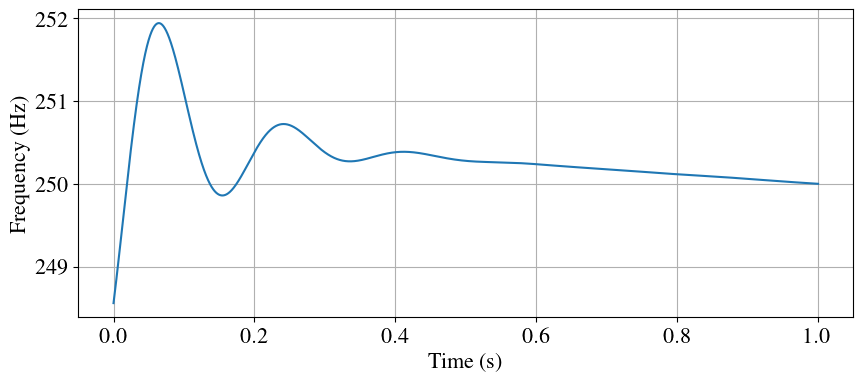

In [49]:
buffer_size = 512; Fs = 22500
length = Fs/buffer_size # length in frames (here set to be 1 second)

Ts = 1/Fs
F0 = 250
alpha = 0.13  # Arbitrary chosen
beta = 0.6  # Arbitrary chosen
gamma = 12 * 2 * np.pi / 25  # 4 full sine wave cycle every 25 frames
theta = 5
phi = 0.01

# Define the function for the F0 contour
def F0_contour(x, F0, alpha, beta, gamma, theta):
    x = x*buffer_size/length # use with the time setting only

    contour = F0 * (1 - alpha * x) * np.exp(-beta * x) * np.sin(gamma * x - 0.3*np.pi) - theta*x + F0
    contour = (contour - contour[-1]) * phi + F0

    return contour

# Generate x values corresponding to frame numbers
time = np.arange(0, length*buffer_size*Ts, Ts)

# Calculate the F0 contour
contour = F0_contour(time, F0, alpha, beta, gamma, theta)

# extend the f0 contour with the last frequency value
#contour = np.concatenate([np.full(int(0.2 * Fs), contour[0]), contour])

# add a vibrato effect
vibrato = 3 # Hz
t = np.arange(0, len(contour)/Fs, 1/Fs)
#modulation = 0.3 * np.sin(2 * np.pi * vibrato * t) # * 1/(1+np.exp(-5*t+5))
#contour = contour + modulation

fig, ax = plt.subplots(1)
fig.set_size_inches(10, 4)
ax.plot(t, contour)
#plt.title('F0 Contour')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (Hz)')
ax.grid(True)

#plt.savefig('/home/jorgep/OneDrive_JPais/Faculdade/Mestrado/Tese/txt/meec-distrib-v2022/figures/chapter4/f0Contour.pdf', format='pdf', dpi = 300)

Text(0.5, 8.919092567098636, 'Time (s)')

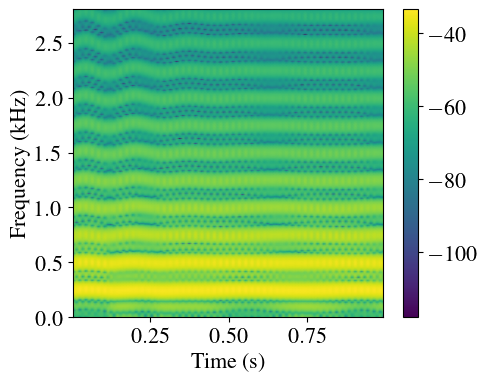

In [50]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times']
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 16

pulse1 = lfPulse(contour, FS)
t = np.arange(0, len(contour)/FS, 1/FS)
pulse2 = v_glotlf(1, t*contour)

# plot spectrograms
fig, ax = plt.subplots()
fig.set_size_inches(5, 4)
f, t, Sxx = spectrogram(pulse1, FS, nfft=1024*4)
im = ax.pcolormesh(t, f[:512]/1e3, 10 * np.log10(Sxx)[:512], shading='gouraud')
ax.set_ylabel('Frequency (kHz)')
ax.set_xlabel('Time (s)')
fig.colorbar(im, ax=ax)
plt.savefig('/home/jorgep/OneDrive_JPais/Faculdade/Mestrado/Tese/txt/meec-distrib-v2022/figures/chapter4/discreteLFspec.pdf', format='pdf', dpi = 300, bbox_inches='tight')

f, t, Sxx = spectrogram(pulse2, FS, nfft=1024*4)
im = ax.pcolormesh(t, f[:512]/1e3, 10 * np.log10(Sxx)[:512], shading='gouraud')
ax.set_ylabel('Frequency (kHz)')
ax.set_xlabel('Time (s)')
#fig.colorbar(im, ax=ax)

#plt.savefig('/home/jorgep/OneDrive_JPais/Faculdade/Mestrado/Tese/txt/meec-distrib-v2022/figures/chapter4/continuousLFspec.pdf', format='pdf', dpi = 300, bbox_inches='tight')


(0.0, 0.1)

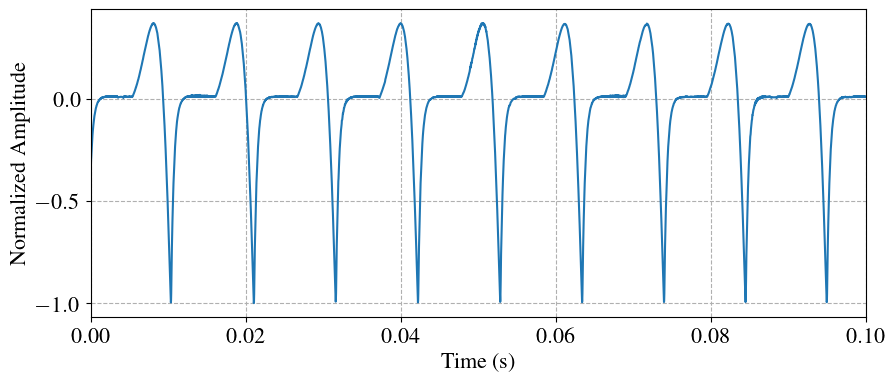

In [51]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times']
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 16

fs, audio_data = wavfile.read('/home/jorgep/Documents/goodPulse.wav')

audio_data = audio_data[:, 0]
audio_data = audio_data[int(2.5*fs):int(2.6*fs)]
audio_data = audio_data / np.max(np.abs(audio_data))

t = np.arange(0, len(audio_data)/fs, 1/fs)

fig, ax = plt.subplots()
fig.set_size_inches(10, 4)
ax.plot(t, audio_data)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Normalized Amplitude')
ax.grid(True, linestyle='--')
ax.set_xlim([0, 0.1])

#plt.savefig('/home/jorgep/OneDrive_JPais/Faculdade/Mestrado/Tese/txt/meec-distrib-v2022/figures/chapter4/pulseSuccess.pdf', format='pdf', dpi = 300, bbox_inches='tight')

(0.0, 0.05)

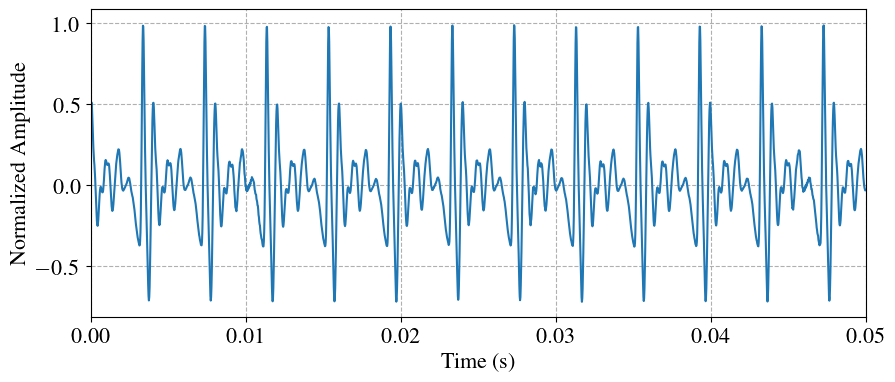

In [52]:
from librosa import resample
FS = 22050; N = 1024; N2 = N//2
hsin = np.sin(np.pi*(0.5 + np.arange(N))/N) # sine window

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times']
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 16

fs, audio_data = wavfile.read('/home/jorgep/Documents/vowel.wav')
audio_data = resample(audio_data.astype(np.float32), orig_sr=fs, target_sr=FS)

audio_data = audio_data[:, 0]
audio_data = audio_data[int(5*fs):int(5.5*fs)]
audio_data = audio_data / np.max(np.abs(audio_data))

t = np.arange(0, len(audio_data)/fs, 1/fs)

fig, ax = plt.subplots()
fig.set_size_inches(10, 4)
ax.plot(t, audio_data)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Normalized Amplitude')
ax.grid(True, linestyle='--')
ax.set_xlim([0, 0.05])

#plt.savefig('/home/jorgep/OneDrive_JPais/Faculdade/Mestrado/Tese/txt/meec-distrib-v2022/figures/chapter5/filteredPulses.pdf', format='pdf', dpi = 300, bbox_inches='tight')

Text(0, 0.5, 'Magnitude (dB)')

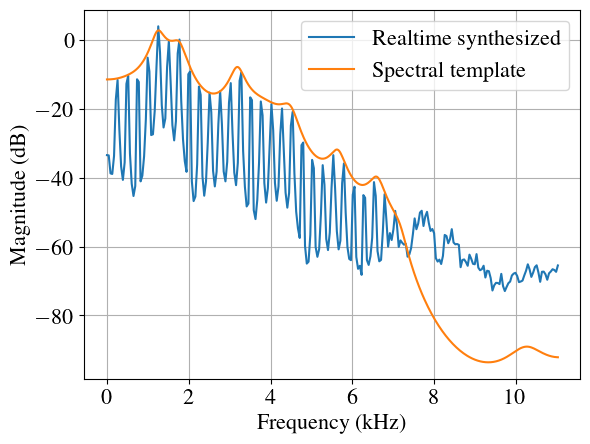

In [53]:
N = 1024

f, psd = welch(audio_data, fs = FS, nfft=N, window=hsin)
psd = 10 * np.log10(2*N*psd)

mat = loadmat('/home/jorgep/OneDrive_JPais/Faculdade/Mestrado/Tese/data/templatesAJF/sofia_a_hlpc.mat')
template = mat['sumhLPC'][0] - 100

fig, ax = plt.subplots()
ax.plot(np.linspace(0, FS/2, 256)/1e3, psd[:N2//2], label='Realtime synthesized')
ax.plot(np.linspace(0, FS/2, 512)/1e3, template-13, label='Spectral template')
ax.legend()
ax.grid(True)
ax.set_xlabel("Frequency (kHz)")
ax.set_ylabel("Magnitude (dB)")

#plt.savefig('/home/jorgep/OneDrive_JPais/Faculdade/Mestrado/Tese/txt/meec-distrib-v2022/figures/chapter5/realtimeSpectrum.pdf', format='pdf', dpi = 300, bbox_inches='tight')

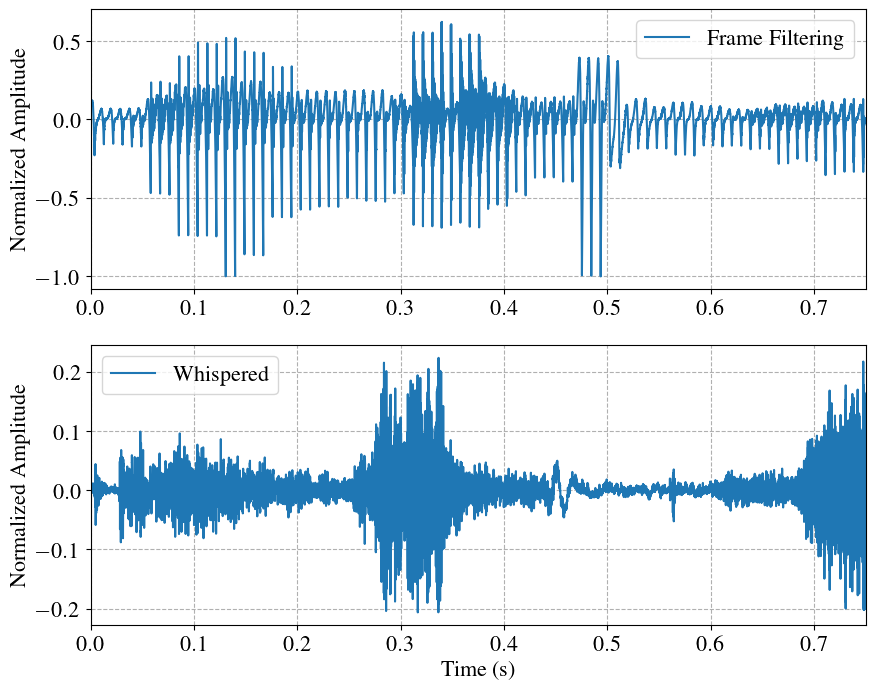

In [140]:
from librosa import resample
FS = 22050; N = 1024; N2 = N//2
hsin = np.sin(np.pi*(0.5 + np.arange(N))/N) # sine window

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times']
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 16

fs, audio_data = wavfile.read('/home/jorgep/Documents/frameFiltering.wav')

#audio_data = audio_data[:, 0]
audio_data = audio_data[int(5.25*fs):int(6*fs)]
#audio_data = audio_data[int(3.75*fs):]
audio_data = audio_data / np.max(np.abs(audio_data))

t = np.linspace(0, len(audio_data)/fs, len(audio_data))

# plot the stereo channels in different subplots
fig, ax = plt.subplots(2, 1)
fig.set_size_inches(10, 8)
ax[0].plot(t, audio_data[:, 0], label='Frame Filtering')
ax[1].plot(t, audio_data[:, 1], label='Whispered')
ax[1].set_xlabel('Time (s)')
ax[0].set_ylabel('Normalized Amplitude')
ax[1].set_ylabel('Normalized Amplitude')
ax[0].grid(True, linestyle='--')
ax[1].grid(True, linestyle='--')
ax[0].legend()
ax[1].legend()
ax[0].set_xlim([0, 0.75])
ax[1].set_xlim([0, 0.75])

plt.savefig('/home/jorgep/OneDrive_JPais/Faculdade/Mestrado/Tese/txt/meec-distrib-v2022/figures/chapter6/framefiltering.pdf', format='pdf', dpi = 300, bbox_inches='tight')

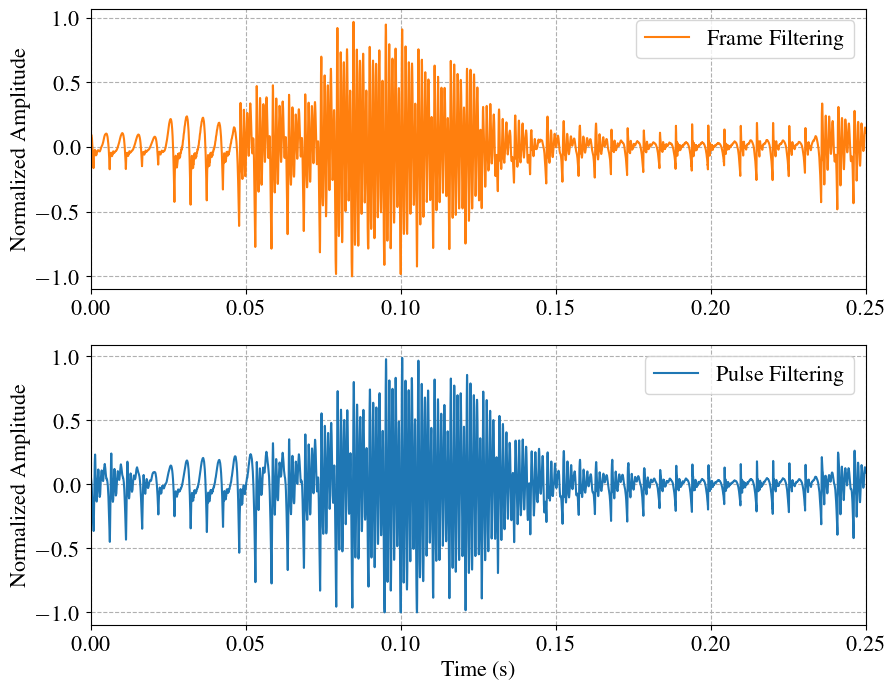

In [183]:
from librosa import resample
FS = 22050; N = 1024; N2 = N//2
hsin = np.sin(np.pi*(0.5 + np.arange(N))/N) # sine window

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times']
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 16

fs, audio_data1 = wavfile.read('/home/jorgep/Desktop/SPF05_Aviao_1_frameFiltering.wav')
fs, audio_data2 = wavfile.read('/home/jorgep/Desktop/SPF05_Aviao_2_pulseFiltering.wav')

slice = np.arange(int(2*fs), int(2.25*fs))

audio_data1 = audio_data1[slice, 0]
audio_data2 = audio_data2[slice, 0]

audio_data1 = audio_data1 / np.max(np.abs(audio_data1))
audio_data2 = audio_data2 / np.max(np.abs(audio_data2))

t = np.linspace(0, len(audio_data1)/fs, len(audio_data1))

# plot the stereo channels in different subplots
fig, ax = plt.subplots(2, 1)
fig.set_size_inches(10, 8)
ax[0].plot(t, audio_data1, label='Frame Filtering', color='tab:orange')
ax[1].plot(t, audio_data2, label='Pulse Filtering', color='tab:blue')
ax[1].set_xlabel('Time (s)')
ax[0].set_ylabel('Normalized Amplitude')
ax[1].set_ylabel('Normalized Amplitude')
ax[0].grid(True, linestyle='--')
ax[1].grid(True, linestyle='--')
ax[0].legend()
ax[1].legend()
ax[0].set_xlim([0, 0.25])
ax[1].set_xlim([0, 0.25])

plt.savefig('/home/jorgep/OneDrive_JPais/Faculdade/Mestrado/Tese/txt/meec-distrib-v2022/figures/chapter6/electrolarynx.pdf', format='pdf', dpi = 300, bbox_inches='tight')

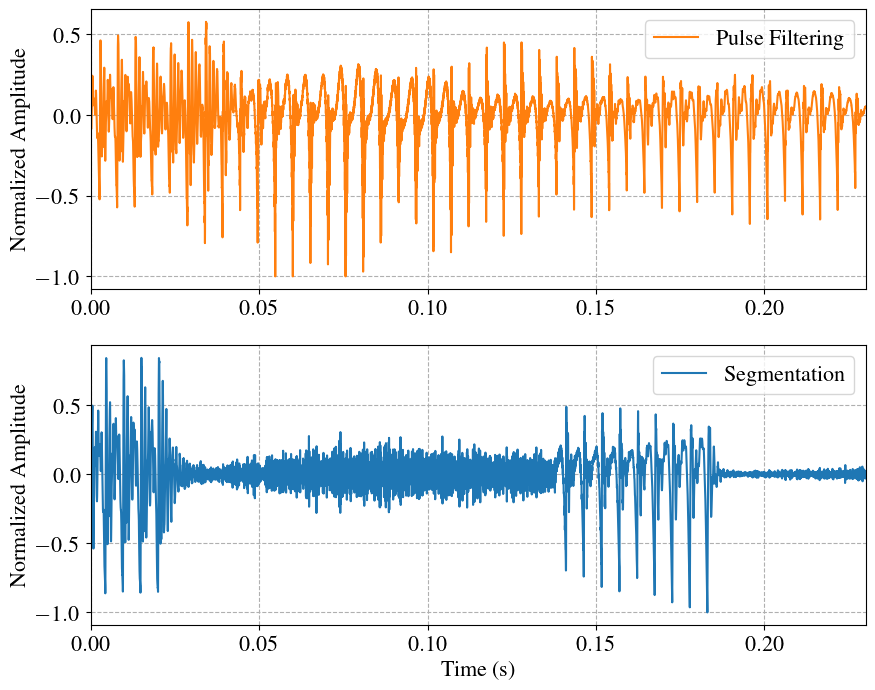

In [191]:
from librosa import resample
FS = 22050; N = 1024; N2 = N//2
hsin = np.sin(np.pi*(0.5 + np.arange(N))/N) # sine window

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times']
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 16

fs, audio_data2 = wavfile.read('/home/jorgep/Desktop/SPF05_Aviao_3_segmentedF0.wav')
fs, audio_data1 = wavfile.read('/home/jorgep/Desktop/SPF05_Aviao_2_pulseFiltering.wav')

slice = np.arange(int(4.46*fs), int(4.7*fs))

audio_data1 = audio_data1[slice, 0]
audio_data2 = audio_data2[slice, 0]

audio_data1 = audio_data1 / np.max(np.abs(audio_data1))
audio_data2 = audio_data2 / np.max(np.abs(audio_data2))

t = np.linspace(0, len(audio_data1)/fs, len(audio_data1))

# plot the stereo channels in different subplots
fig, ax = plt.subplots(2, 1)
fig.set_size_inches(10, 8)
ax[0].plot(t, audio_data1, label='Pulse Filtering', color='tab:orange')
ax[1].plot(t, audio_data2, label='Segmentation', color='tab:blue')
ax[1].set_xlabel('Time (s)')
ax[0].set_ylabel('Normalized Amplitude')
ax[1].set_ylabel('Normalized Amplitude')
ax[0].grid(True, linestyle='--')
ax[1].grid(True, linestyle='--')
ax[0].legend()
ax[1].legend()
ax[0].set_xlim([0, 0.23])
ax[1].set_xlim([0, 0.23])

plt.savefig('/home/jorgep/OneDrive_JPais/Faculdade/Mestrado/Tese/txt/meec-distrib-v2022/figures/chapter6/segmentation.pdf', format='pdf', dpi = 300, bbox_inches='tight')